# GESTURE RECOGNITION PROJECT

## Problem Statement :

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up: Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds
- Stop: Pause the movie



## Project Objective and Model Architecture:
Train a model that can correctly identify the 5 hand gestures based on the Test Data.
For the same, there are two Architectures suggested.

- 3D Convs and
- CNN-RNN Stack

3D convolutions are a natural extension to the 2D convolutions. Just like in 2D conv, you move the filter in two directions (x and y), in 3D conv, you move the filter in three directions (x, y and z). In this case, the input to a 3D conv is a video (which is a sequence of 30 RGB images).
CNN-RNN stack- The conv2D network will extract a feature vector for each image, and a sequence of these feature vectors is then fed to an RNN-based network. The output of the RNN is a regular SoftMax (for a classification problem such as this one).



In [1]:
# Importing the necessary libraries

import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)


In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
#from keras.layers.recurrent import LSTM
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout
tf.keras.optimizers.Adam

keras.optimizer_v2.adam.Adam

In [5]:
project_folder='/home/datasets/Project_data'

# Plotting

In [6]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].grid()
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].grid()
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

# Generator

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [7]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=16,batch_size=8,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    
                 
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

# Model

Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# Convolution 3D Model

In [8]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        #optimiser = optimizers.Adam()
        optimizer = tf.keras.optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer = tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=128,image_width=128)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=10)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 128, 128, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 128, 128, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 128, 128, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 64, 64, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 64, 64, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 64, 64, 32)    0

2023-03-10 14:57:08.001173: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-03-10 14:57:08.001237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


### Sample Cropping

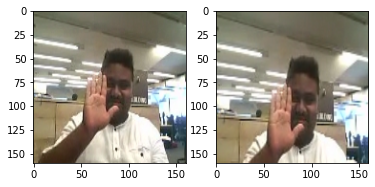

In [10]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=10)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   
plt.show()

In [52]:
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1146565
Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.5464 - categorical_accuracy: 0.4193
Epoch 00001: val_loss improved from inf to 5.54409, saving model to model_init_2023-03-0912_08_32.638318/model-00001-1.54643-0.41931-5.54409-0.21000.h5
67/67 [==============================] - 163s 2s/step - loss: 1.5464 - categorical_accuracy: 0.4193 - val_loss: 5.5441 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.2695 - categorical_accuracy: 0.5204
Epoch 00002: val_loss improved from 5.54409 to 4.82499, saving model to model_init_2023-03-0912_08_32.638318/model-00002-1.26953-0.52036-4.82499-0.20000.h5
67/67 [==============================] - 161s 2s/step - loss: 1.2695 - categorical_accuracy: 0.5204 - val_loss: 4.8250 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 0.9215 - categorical_accuracy: 0.6456
Epoch 00003: val_l

In [ ]:
The above model is performing well.The training accuracy is 89% and the validation accuracy is 84% ,also validation loss is decreasing.

In [11]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=128,image_width=128)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size= 20,num_epochs=10)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1146565
Epoch 1/10


2023-03-10 14:58:07.459978: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.6179 - categorical_accuracy: 0.4389
Epoch 00001: val_loss improved from inf to 1.86668, saving model to model_init_2023-03-1014_58_01.560953/model-00001-1.61790-0.43891-1.86668-0.16000.h5
34/34 [==============================] - 169s 5s/step - loss: 1.6179 - categorical_accuracy: 0.4389 - val_loss: 1.8667 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.1044 - categorical_accuracy: 0.5747
Epoch 00002: val_loss did not improve from 1.86668
34/34 [==============================] - 168s 5s/step - loss: 1.1044 - categorical_accuracy: 0.5747 - val_loss: 2.9599 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.8272 - categorical_accuracy: 0.6787
Epoch 00003: val_loss did not improve from 1.86668
34/34 [==============================] - 162s 5s/step - loss: 0.8272 - categorical_accuracy: 0.6787 - val

clearly we can see the val_loss did not improve and the model is overfitting

In [24]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size= 15,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/15
45/45 [==============================] - ETA: 0s - loss: 1.6797 - categorical_accuracy: 0.3876
Epoch 00001: val_loss improved from inf to 4.04314, saving model to model_init_2023-03-0916_42_33.080839/model-00001-1.67966-0.38763-4.04314-0.16000.h5
45/45 [==============================] - 160s 4s/step - loss: 1.6797 - categorical_accuracy: 0.3876 - val_loss: 4.0431 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - ETA: 0s - loss: 1.0729 - categorical_accuracy: 0.5671
Epoch 00002: val_loss did not improve from 4.04314
45/45 [==============================] - 158s 4s/step - loss: 1.0729 - categorical_accuracy: 0.5671 - val_loss: 5.6568 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - ETA: 0s - loss: 0.8616 - categorical_accuracy: 0.6561
Epoch 00003: val_loss did not improve from 4.04314
45/45 [==============================] - 156s 4s/step - loss: 0.8616 - ca

#### Adding droupout layer in the model

In [12]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimizer = tf.keras.optimizers.Adam()
        model.compile(optimizer = tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=30,num_epochs=10)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_9 (Activation)   (None, 10, 80, 80, 32)   

In [22]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/10


2023-03-10 05:41:46.914372: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 1.4167 - categorical_accuracy: 0.4465
Epoch 00001: val_loss improved from inf to 2.12992, saving model to model_init_2023-03-1005_41_40.065622/model-00001-1.41672-0.44646-2.12992-0.16000.h5
23/23 [==============================] - 124s 5s/step - loss: 1.4167 - categorical_accuracy: 0.4465 - val_loss: 2.1299 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 0.8392 - categorical_accuracy: 0.6817
Epoch 00002: val_loss did not improve from 2.12992
23/23 [==============================] - 116s 5s/step - loss: 0.8392 - categorical_accuracy: 0.6817 - val_loss: 2.2396 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 0.6563 - categorical_accuracy: 0.7557
Epoch 00003: val_loss did not improve from 2.12992
23/23 [==============================] - 111s 5s/step - loss: 0.6563 - categorical_accuracy: 0.7557 - val

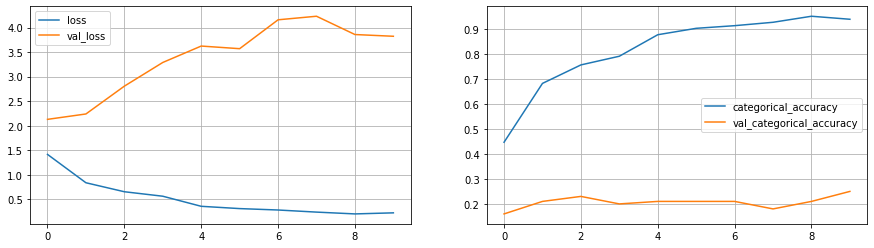

In [23]:
plot(history_model1)

This shows the model is overfitting.

In [14]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_13 (Activation)  (None, 10, 80, 80, 32)   

In [25]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 2.0593 - categorical_accuracy: 0.3544
Epoch 00001: val_loss improved from inf to 4.47111, saving model to model_init_2023-03-1006_14_51.444407/model-00001-2.05929-0.35445-4.47111-0.21000.h5
34/34 [==============================] - 222s 7s/step - loss: 2.0593 - categorical_accuracy: 0.3544 - val_loss: 4.4711 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4603 - categorical_accuracy: 0.5106
Epoch 00002: val_loss did not improve from 4.47111
34/34 [==============================] - 225s 7s/step - loss: 1.4603 - categorical_accuracy: 0.5106 - val_loss: 11.1610 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0978 - categorical_accuracy: 0.6078
Epoch 00003: val_loss did not improve from 4.47111
34/34 [==============================] - 229s 7s/step - loss: 1.0978 - 

#### The val_loss did not improve from 4.47111 so early stopping happed.

# CNN- LSTM Model

In [15]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimizer = tf.keras.optimizers.Adam()
        model.compile(optimizer = tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=128,image_width=128)
rnn_cnn1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=10)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 128, 128, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 128, 128, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 64, 64, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 64, 64, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 64, 64, 32)  

In [30]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 2574949
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.4123 - categorical_accuracy: 0.4027
Epoch 00001: val_loss improved from inf to 1.67747, saving model to model_init_2023-03-1007_04_18.947703/model-00001-1.41226-0.40271-1.67747-0.23000.h5
34/34 [==============================] - 294s 9s/step - loss: 1.4123 - categorical_accuracy: 0.4027 - val_loss: 1.6775 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.0726 - categorical_accuracy: 0.5588
Epoch 00002: val_loss did not improve from 1.67747
34/34 [==============================] - 310s 9s/step - loss: 1.0726 - categorical_accuracy: 0.5588 - val_loss: 2.3228 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.9284 - categorical_accuracy: 0.6403
Epoch 00003: val_loss did not improve from 1.67747
34/34 [==============================] - 293s 9s/step - loss: 0.9284 - c

In [ ]:
The Validation loss did not improved much and the model is overfitting

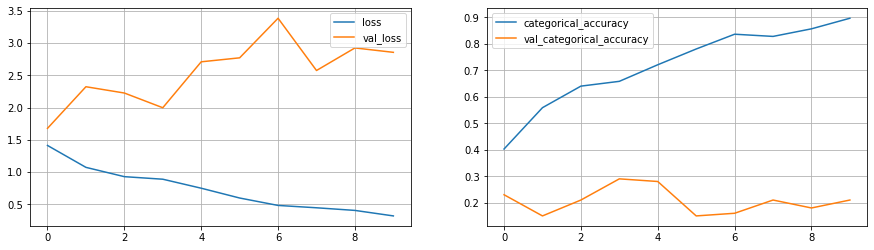

In [31]:
plot(history_model8)

# CNN GRU Model

In [18]:
class RNNCNN2(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimizer = tf.keras.optimizers.Adam()
        model.compile(optimizer = tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=128,image_width=128)
rnn_cnn2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.5)
rnn_cnn2_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 128, 128, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 128, 128, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 64, 64, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 64, 64, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 20, 64, 64, 32)  

In [20]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model9=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 3311205
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.7842 - categorical_accuracy: 0.2738
Epoch 00001: val_loss improved from inf to 3.06569, saving model to model_init_2023-03-1015_33_12.979949/model-00001-1.78422-0.27376-3.06569-0.26000.h5
34/34 [==============================] - 201s 6s/step - loss: 1.7842 - categorical_accuracy: 0.2738 - val_loss: 3.0657 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4174 - categorical_accuracy: 0.3922
Epoch 00002: val_loss improved from 3.06569 to 2.48142, saving model to model_init_2023-03-1015_33_12.979949/model-00002-1.41736-0.39216-2.48142-0.22000.h5
34/34 [==============================] - 198s 6s/step - loss: 1.4174 - categorical_accuracy: 0.3922 - val_loss: 2.4814 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.3514 - categorical_accuracy: 0.4201
Epoch 00003: val_l

# Conclusion

After doing the experiments the convolution 3D model is performing better among all the other model.
- The training accuracy is 89% and the validation accuracy is 84% ,also validation loss is decreasing.
- With image_height=128,image_width=128 and bath_size =10 and frame size =30.